# Чат-бот 

В этом проекте будет реализован чат-бот-«барахольщик»: по продуктовому запросу он будет рекомендовать товары, по остальным запросам он будет отвечать «болталкой» (без фолбека).

В этом проекте нам предоставлены данные некоторого интернет магазина одежды. Наша задача реализовать следующие шаги:
* Обучить классификатор: продуктовый запрос vs. всё остальное (продуктовым можно считать запрос, который равен названию или описанию товара).
* Добавить логику поиска похожих товаров по продуктовому запросу.
* На не продуктовый запрос бот будет отвечать "болталкой".
* Вся логика должна быть завёрнута в метод get_answer(). Ответ на продуктовый запрос должен иметь вид "product_id title".

In [42]:
# Импортируем нужные библиотеки
import pandas as pd
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation
import re
import os
import string
import annoy
import codecs
from gensim.models import Word2Vec
from tqdm.notebook import tqdm
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, metrics
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import pickle

## 1. Загрузка и обработка данных

Загрузим датасет с товарами:

In [252]:
product_data = pd.read_csv('ProductsDataset.csv')
print(product_data.shape)
product_data.head(3)

(35548, 7)


,title,descrirption,product_id,category_id,subcategory_id,properties,image_links
0,Юбка детская ORBY,"Новая, не носили ни разу. В реале красивей чем...",58e3cfe6132ca50e053f5f82,22.0,2211,"{'detskie_razmer_rost': '81-86 (1,5 года)'}",http://cache3.youla.io/files/images/360_360/58...
1,Ботильоны,"Новые,привезены из Чехии ,указан размер 40,но ...",5667531b2b7f8d127d838c34,9.0,902,"{'zhenskaya_odezhda_tzvet': 'Зеленый', 'visota...",http://cache3.youla.io/files/images/360_360/5b...
2,Брюки,Размер 40-42. Брюки почти новые - не знаю как ...,59534826aaab284cba337e06,9.0,906,{'zhenskaya_odezhda_dzhinsy_bryuki_tip': 'Брюк...,http://cache3.youla.io/files/images/360_360/59...


Продуктовый запрос соотвествует названию или описанию товара. Добавим новый признак как сумму названия и описания, а также добавим признак метки класса продуктового запроса: 

In [253]:
# Объеденяем названия и описания в один признак
product_data['text'] = product_data['title'] + " " + product_data['descrirption']#.apply(lambda x: str(x))

# Для удобства создадим новый датасет
data = pd.DataFrame()
data['text'] = product_data['text']

# Обозначим  записи  в признаке label как True(продуктовые запросы)
data['label'] = data['text'] == data['text']

# Посмотрим на результат
data.head()

,text,label
0,"Юбка детская ORBY Новая, не носили ни разу. В ...",True
1,"Ботильоны Новые,привезены из Чехии ,указан раз...",True
2,Брюки Размер 40-42. Брюки почти новые - не зна...,True
3,"Продам детские шапки Продам шапки,кажда 200р.Р...",True
4,"Блузка Темно-синяя, 42 размер,состояние отличн...",True


Добавим в датасет примеры НЕ продуктовых запросов. Такие запросы загрузим из датасета вопросов на mail.ru:

In [189]:
sentences = [] # список запросов
c = 0 # счетчик (загрузим 35500 запросов, чтобы классы были сбалансированы)

# проходимся по вопросам и записываем из в список
with codecs.open("prepared_answers.txt", "r", "utf-8") as fin:
    for line in tqdm(fin):
        spls = line.split("\t")
        sentences.append(spls[0]) # добавляем только вопрос
        c += 1
        if c > 35500:
            break

# Создадим датасет не продуктовых запросов        
not_product_data = pd.DataFrame()
not_product_data['text'] = pd.Series(sentences) # добавляем загруженные запросы
not_product_data['label'] = not_product_data['text'] != not_product_data['text'] # помечаем класс как False

# посмотрим на результат
not_product_data.head()

0it [00:00, ?it/s]

,text,label
0,,False
1,Как парни относятся к цветным линзам? Если у д...,False
2,"Что делать, сегодня нашёл 2 миллиона рублей? .",False
3,Эбу в двенашке называется Итэлма что за эбу? .,False
4,академия вампиров. сколько на даный момент час...,False


Объеденим датасеты и закодируем label:

(71049, 2)


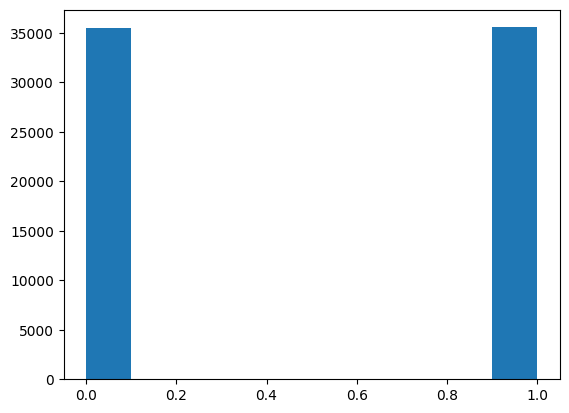

In [190]:
# общий датасет 
concat_df = pd.concat([not_product_data, data]).reset_index(drop=True)

# кодируем 
concat_df['label'] = concat_df['label']. apply(lambda x: 1 if x == True else 0)

# посмотрим на размерность
print(concat_df.shape)

# посмотрим на баланс классов
plt.hist(concat_df['label'])
plt.show()

Как мы видим, классы сбалансированны, что позволяет использовать accuracy как простую и интерпретируемую метрику, хорошо показывающую качество модели. 

Осталось только предобработать текст: 

In [191]:
# Для фильтрации пунктуации
exclude = set(string.punctuation)
# Для приведения слов в начальной форме
morpher = MorphAnalyzer()

# Для фильтрации стоп-слов
sw = get_stop_words("ru")

# Обернем обработку в функцию 
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split() # удаляем пунктуацию
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls] # нормализируем и лемматизируем
    spls = [i for i in spls if i not in sw and i != ""] # удаляем стоп-слова
    return " ".join(spls)

In [192]:
# обработаем текст
concat_df['text'] = concat_df['text'].apply(lambda x: preprocess_txt(str(x)))

# смотрим результат
concat_df.head()

,text,label
0,,0
1,парень относиться цветной линза девушка зелёны...,0
2,делать найти 2 миллион рубль,0
3,эбу двенашка называться итэлма эбу,0
4,академия вампир даный момент часть книга акаде...,0


## 2. Классификация запроса

Создадим обучающею и тестовую выборки:

In [195]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(concat_df['text'], concat_df['label'])
print("Train size:", train_x.shape)
print("Test size:", valid_x.shape)

Train size: (53286,)
Test size: (17763,)


Чтобы текст можно было передать в модель - сделаем его векторизацию:

In [196]:
# Обучаем векторизатор
count_vect = CountVectorizer().fit(train_x.values)

# Получаем выборки с извлеченными признаками
xtrain_count = count_vect.transform(train_x)
xvalid_count = count_vect.transform(valid_x)

В качестве классификатора обучим логистическую регрессию:

In [197]:
# Обучаем
lr = linear_model.LogisticRegression()
lr.fit(xtrain_count,train_y)

# Сделаем предсказание и посчитаем метрику
predictions = lr.predict(xvalid_count)
print("accuracy_score:", metrics.accuracy_score(predictions, valid_y))

accuracy_score: 0.9823228058323481


Как видим логистическая регрессия отлично справилась с классификацией. Сохраним модель:

In [198]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('lr_product.pkl', 'wb') as output:
    pickle.dump(lr, output)

Попробуем загрузить модель и передать в неё несколько запросов:

In [199]:
# Загружаем
with open('lr_product.pkl', 'rb') as pkl_file:
    lr_from_file = pickle.load(pkl_file)

# Запросы    
product = 'Купить мужские брюки'
not_product = 'Как приготовить борщь?'

# Классификация запросов
print("Продуктовый запрос:", lr_from_file.predict(count_vect.transform([preprocess_txt(product)])))
print("Не продуктовый запрос:", lr_from_file.predict(count_vect.transform([preprocess_txt(not_product)])))

Продуктовый запрос: [1]
Не продуктовый запрос: [0]


Отлично! Классификатор работает корректно.

## 3. Поиск похожих товаров

Обработаем текст для дальнейшей свертки в векторное представление:

In [254]:
product_data['text'] = product_data['text'].apply(lambda x: preprocess_txt(str(x)).split())
product_data['text'].head()

0    [юбка, детский, orby, новый, носить, реал, кра...
1    [ботильон, новыепривезти, чехия, указать, разм...
2    [брюки, размер, 4042, брюки, новый, знать, мер...
3    [продать, детский, шапка, продать, шапкикажда,...
4    [блузка, темносиний, 42, размерсостояние, отли...
Name: text, dtype: object

Обучим модель Word2Vec на текстах:

In [273]:
modelWV = Word2Vec(sentences=product_data['text'], vector_size=20, min_count=1, window=5)

Для того, чтобы быстро находить айтемы положим эмбединги их тайтлов в ANN индекс:

In [274]:
# Создадим объект индекса
ft_index_shop = annoy.AnnoyIndex(20 ,'angular')

index_map_shop = {}
counter = 0

for i in tqdm_notebook(range(len(product_data))):
    n_wv2 = 0
    index_map_shop[counter] = (product_data.loc[i, "product_id"], product_data.loc[i, "title"])
    vector_ft = np.zeros(20)
    # Каждое слово обернем в эмбеддинг
    for word in product_data.loc[i, "text"]:
        if word in modelWV.wv:
            vector_ft += modelWV.wv[word]
            n_wv2 += 1
    if n_wv2 > 0:
        vector_ft = vector_ft / n_wv2
    ft_index_shop.add_item(counter, vector_ft)
    counter += 1
    
ft_index_shop.build(10)

C:\Users\ds129\AppData\Local\Temp\ipykernel_14660\763825458.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(product_data))):


  0%|          | 0/35548 [00:00<?, ?it/s]

True

Теперь напишем функцию для поиска похожих товаров. Проходимся по всем словам в запросе, считаем, что вектор запроса - усредненная сумма word2vecов слов, которые входят в него:

In [275]:
def recommend(request):
    request = preprocess_txt(request).split()
    vector_ft = np.zeros(20)
    n_wv2 = 0
    # Каждое слово обернем в эмбеддинг
    for word in request:
        if word in modelWV.wv:
            vector_ft += modelWV.wv[word]
            n_wv2 += 1
    if n_wv2 > 0:
        vector_ft = vector_ft / n_wv2
    # Найдем ближайшие по тайтлу
    rec_items = ft_index_shop.get_nns_by_vector(vector_ft, 5)
    return [index_map_shop[i] for i in rec_items]

Проверим как работает функция (она возращает id и title товаров 5 похожих товаров):

In [318]:
print(recommend("Спортивный костюм детский"))
print(recommend("Свадебное платье"))

[('5a62370e2aecd6791a3388c6', 'Детский костюм'), ('58d8207428c4aaa49cd0deb5', 'Костюм-тройка детский, 135-140'), ('5a6efdd6bd36c0190d474f54', 'Детский костюм'), ('5931752865bcf15ab81a3cf3', 'Костюм домашний'), ('5b2d0085de885472fa0f7052', 'Спортивный костюм')]
[('5a6ab42ede88541b187b1b6b', 'Свадебное платье'), ('5bddba2122a44993625eff85', 'Свадебное платье'), ('5b9bac452aecd607ad3483e2', 'Вечерние платье'), ('5ac46019de88543e437e7632', 'Платье вечернее'), ('5a40e17fc6ab9e21370573c2', 'Вечернее платье.')]


Поиск похожих товаров работает корректно!

## 4. Болталка

Ответы на не продуктовые вопросы будем искать среди ответов с mail.ru.
Предобработаем ответы из файла: к каждому вопросу присоединим 1 ответ и запишем в файл на будущее:

In [277]:
question = None
written = False

#Мы идем по всем записям, берем первую строку как вопрос
# и после знака --- находим ответ
with codecs.open("prepared_answers.txt","w", "utf-8") as fout:
    with codecs.open("Otvety.txt", "r", "utf-8") as fin:
        for line in tqdm(fin):
            if line.startswith("---"):
                written = False
                continue
            if not written and question is not None:
                fout.write(question.replace("\t", " ").strip() + "\t" + line.replace("\t", " "))
                written = True
                question = None
                continue
            if not written:
                question = line.strip()
                continue

0it [00:00, ?it/s]

Загрузим и обработаем ответы:

In [279]:
otvety_sentences = []
c = 0

with codecs.open("Otvety.txt", "r", "utf-8") as fin:
    for line in tqdm(fin):
        spls = preprocess_txt(line)
        otvety_sentences.append(spls)
        c += 1
        if c > 300000:  # загрузим 300к ответов (чем больше - тем лучше, но дольше :))
            break

0it [00:00, ?it/s]

Векторизируем ответы с помощью Word2Vec:

In [280]:
otvety_sentences = [i for i in otvety_sentences if len(i) > 2]
modelWV_otvety = Word2Vec(sentences=sentences, vector_size=100, min_count=1, window=5)

Складываем в индекс вопросы:

In [281]:
index_bot = annoy.AnnoyIndex(100 ,'angular')

index_map_bot = {}
counter = 0

with codecs.open("prepared_answers.txt", "r", "utf-8") as f:
    for line in tqdm(f):
        n_w2v = 0
        spls = line.split("\t")
        index_map_bot[counter] = spls[1]
        question = preprocess_txt(spls[0])
        vector = np.zeros(100)
        for word in question:
            if word in modelWV_otvety.wv:
                vector += modelWV_otvety.wv[word]
                n_w2v += 1
        if n_w2v > 0:
            vector = vector / n_w2v
        index_bot.add_item(counter, vector)
            
        counter += 1

index_bot.build(10)

0it [00:00, ?it/s]

True

Теперь реализуем метод, который получит на вход вопрос и найдет ответ к нему. Препроцессим вопрос, находим ближайший вопрос и выбираем ответ на него:

In [282]:
def find_answer(question):
    preprocessed_question = preprocess_txt(question)
    n_w2v = 0
    vector = np.zeros(100)
    for word in preprocessed_question:
        if word in modelWV_otvety.wv:
            vector += modelWV_otvety.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index_bot.get_nns_by_vector(vector, 1)
    return index_map_bot[answer_index[0]]

Посмотрим как работает функция:

In [289]:
print(find_answer('Как приготовить утку?'))
print(find_answer('Где оформить заграничный паспорт?'))
print(find_answer('Привет, как дела?'))

Гусь, утка фаршированные.<br>Подготовленную тушку, заправленную «в кармашек», натираем внутри и снаружи солью, фаршируем картофелем или черносливом, или яблоками через разрез в брюшке, зашиваем нитками и жарим в горячей духовке на противне 1,5 - 2 часа, периодически поливая вытопившимся жиром и соком.<br>При подаче на стол у птицы удаляем нитки, вынимаем ложкой из брюшка начинку, разрезаем тушку на порционные куски и обкладываем их вынутым фаршем, поливаем соком, выделившимся при жарке, и растопленным сливочным маслом.<br>Для начинки подбираем клубни картофеля среднего размера, очищаем и слегка обжариваем; или очищенные от кожицы и семян яблоки (лучше антоновка) нарезаем на дольки, посыпаем сахаром; или предварительно замоченный чернослив с удаленной косточкой, посыпанный сахаром.<br><br>Продукты для фаршированного гуся или утки: 1 тушка гуся или утки, соль. <br>Начинка для гуся: 1600 г картофеля, 60 г маргарина или 1500 г вареного чернослива без косточек, 200 г сахара, или 1800 г ябло

Как видим бот отвечает не всегда корректно. Чтобы бот отвечал точнее - можно загрузить больше вопросов и ответов(в данном проекте число вопросов было ограничено ради экономии времени выполнения кода).

## 5. Чат-бот

Теперь объединим классификатор, поиск товаров и болталку в одну функцию:

In [295]:
def get_answer(request):
    if lr_from_file.predict(count_vect.transform([preprocess_txt(request)])) == 1: # продуктовый запрос
        return recommend(request)
    else: # не продуктовый запрос
        return find_answer(request)     

Сделаем пару тестов:

In [309]:
get_answer('Юбка детская ORBY')

[('5b60b60b074b3e2ff548cf07', 'Костюм летний'),
 ('5a2a65366c86cb898827c632', 'Летний Джинсовый костюм.'),
 ('5ac0f3e3f2026326a11d8882', 'Летний костюм'),
 ('5af4fd44a09cd5c35b0d156d', 'Сарафан'),
 ('59e364c3dbdf0f21841e9c78', 'Сарафан школьный')]

In [310]:
get_answer('Где ключи от танка')

'Мои любимчики Pink cream69!!!!. \n'

In [311]:
get_answer('Мужская обувь')

'<p>Йо́сеф Гу́мпаль (чеш. Josef Humpál; 30 января 1918, Оломоуц — 20 декабря 1984, Невшатель) — чехословацкий футболист и футбольный тренер.</p>   <h2>Клубная карьера</h2> <h2>Тренерская карьера</h2> <h2>Достижения</h2> <ul> <li>Чемпион Второго дивизиона Франции: 1946/47</li> <li>Лучший бомбардир Первого дивизиона Франции: 1949</li> <li>Лучший бомбардир Второго дивизиона Франции: 1947</li> <li>Рекордсмен «Сошо» по количеству голов в сезоне: 50 голов</li> <li>Рекордсмен «Сошо» по количеству голов в сезоне лиги: 45 голов</li> </ul> <h2>Статистика выступлений</h2> <p>Источник:</p> <ul> <li>Jozef Humpal\xa0(фр.). Pari-et-gagne.com. Проверено 23 октября 2015.</li> </ul> <h2>Примечания</h2> <h2>Ссылки</h2> <ul> <li>Профиль футболиста на сайте Footballdatabase.eu \xa0(фр.)</li> </ul>. \n'

In [313]:
get_answer('Куртка зимняя')

[('5c028c76226e481a603511bb', 'Куртка зимняя'),
 ('5beeca379e94ba89b16da55a', 'Куртка'),
 ('5bb1d3fe0fff81421a6608d1', 'Зимняя куртка кожанная'),
 ('5a53768ed138b3276d1abf82', 'Куртка зимняя'),
 ('5bc780ce5eaa9e70a769eb15', 'Куртка зимняя "MTFORCE"')]

В большинстве случаев бот работает корректно, но иногда классифицирует запрос не верно. Улучшить качество работы бота можно увеличив число примеров для обучения линейной регрессии и векторизаторов.